### Linear Regression with tf.eager()

In [1]:
# Importing and starting tf.eager()
# Currently tf is a bit picky, eager mode needs to be switched 
# on at the start and you are only allowed to switch it on once.
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from __future__ import absolute_import, division, print_function

print('TF Version:', tf.__version__)

# Enabling eager mode for tensorflow.
# This check makes running this cell (and hence enabling tf-eager)idempotent.
# Tick by Thomas Fischbacher
try:
  tf.enable_eager_execution()
  print('TF-Eager mode is enabled.')
except ValueError as exn:
  if tf.executing_eagerly():
    print('TF-Eager mode already was enabled.')
  elif 'must be called at program startup' in exn.args[0]:
    print ('Eager-Mode must be enabled at start-time.\n'
           'Please Restart the Runtime '
           '([Runtime] -> [Restart Runtime] or Ctrl-M).')
  else:
    # Unknown situation, re-raise exception.
    raise
    
tfe = tf.contrib.eager

TF Version: 1.10.1
TF-Eager mode is enabled.


In [2]:
tf.__version__ #You should get a version > 1.10.1

'1.10.1'

In [0]:
x = [22, 41, 52, 23, 41, 54, 24, 46, 56, 27, 47, 57, 28, 48, 58,  9, 
     49, 59, 30, 49, 63, 32, 50, 67, 33, 51, 71, 35, 51, 77, 40, 51, 81]
y = [131, 139, 128, 128, 171, 105, 116, 137, 145, 106, 111, 141, 114, 
     115, 153, 123, 133, 157, 117, 128, 155, 122, 183,
     176,  99, 130, 172, 121, 133, 178, 147, 144, 217]
x = np.asarray(x, np.float32)
y = np.asarray(y, np.float32)

### Numpy code for the RSS

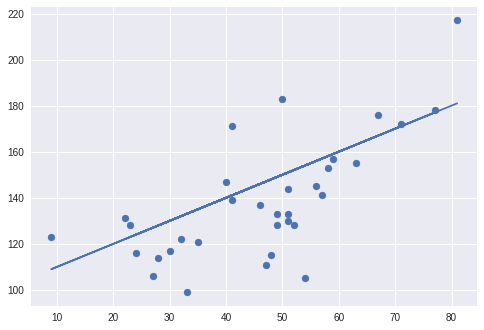

In [4]:
a = 1
b = 100
plt.scatter(x,y)
plt.plot(x,(a*x)+b)

### TASK: Calculate the RSS using numpy

How good is the fit? Calculate the sum of all quadratic differences?

$$
\hat{y} = a*x + b \\
RSS = \sum_i (\hat{y_i} - y_i)^2
$$

The result should be 13469.0

In [5]:
y_hat = a*x + b
r = (y_hat - y)
np.sum(r**2)

13469.0

### TASK: Calculate the RSS using TensorFlow Eager

In [6]:
# Defining the graph (construction phase)
a  = tfe.Variable(1.0) #We can optimize them later
b = tfe.Variable(100.0)
x_ = tfe.Variable(x)   #We don't need placeholders for tf.eager()
y_ = tfe.Variable(y)
y_hat_ = a*x_ + b
r_ = y_ - y_hat_
rss = tf.reduce_sum(tf.square(y_ - y_hat_))
rss

<tf.Tensor: id=44, shape=(), dtype=float32, numpy=13469.0>

In [7]:
# Calculate the gradients for given values of a and b
tape = tf.GradientTape()
with tape:
    y_hat_ = a*x_ + b
    r_ = y_ - y_hat_
    rss = tf.reduce_sum(tf.square(y_ - y_hat_))
tape.gradient(rss, [a,b])

[<tf.Tensor: id=82, shape=(), dtype=float32, numpy=20944.0>,
 <tf.Tensor: id=75, shape=(), dtype=float32, numpy=494.0>]

In [0]:
# We now use the gradients and feed them into the optimizer to go down one gradient step
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

In [9]:
for i in range(1000):
    tape = tf.GradientTape() #Each time a tape needs to be provided
    with tape:
        y_hat_ = a*x_ + b
        r_ = y_ - y_hat_
        rss = tf.reduce_sum(tf.square(y_ - y_hat_))
    grads = tape.gradient(rss, [a,b])
    optimizer.apply_gradients(zip(grads, [a,b]))
    if (i % 100 == 0): #Trick not to print so often
        print(a.numpy(), b.numpy(), rss.numpy())

0.99 99.99 13469.0
0.87744635 99.43815 12031.096
0.89086044 98.76641 11974.89
0.9049999 98.03557 11917.453
0.9194064 97.290085 11862.875
0.9337075 96.54967 11812.686
0.9476976 95.82512 11767.457
0.96125203 95.12296 11727.289
0.9742896 94.44748 11692.058
0.986753 93.80167 11661.496


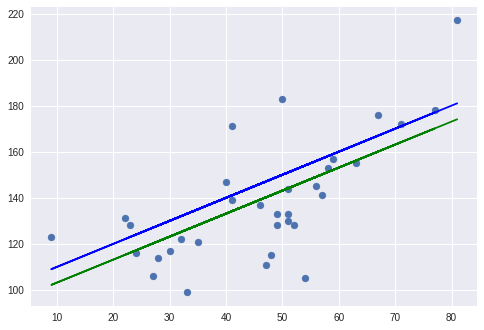

In [10]:
plt.scatter(x,y)
plt.plot(x,(1*x)+100, c='b') # Initial guess
plt.plot(x,(a*x)+b, c='g')   # After optimizing

### Task: nicer with functions
Create a function, which takes a,b as input and returns RSS. Use this function instead of the code above.

## Keras code 

In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1,input_shape=(1,)))
model.add(tf.keras.layers.Activation('linear'))


# An alternative definition of the model
# model = tf.keras.Sequential(
#     [
#       tf.keras.layers.Dense(1,input_shape=(1,), activation='linear') 
#       # Here could be many layers
#     ]
# )

# Note that 
# We don't specify the optimizer here, nor do we compile the model

optimizer = tf.train.AdamOptimizer()
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [13]:
## Setting the weights 
a_ini=np.array(1,dtype="float32",ndmin=2)
b_ini=np.array(100,dtype="float32",ndmin=1)
model.set_weights([a_ini,b_ini])
a_keras,b_keras=model.get_weights()
print("slope=",a_keras[0][0],"intercept=",b_keras[0])

slope= 1.0 intercept= 100.0


In [14]:
for i in range(0,3000):
    model.fit(x=x,y=y,batch_size=33,
                    epochs=1,
                    verbose = 0)
    a,b=model.get_weights()
    if i % 500==0:
        RSS=np.sum(np.square(model.predict(x).reshape(len(x),)-y))
        print("Epoch:",i,"slope=",a[0][0],"intercept=",b[0],"RSS=",RSS)

Epoch: 0 slope= 0.999 intercept= 99.999 RSS= 13447.645
Epoch: 500 slope= 0.87229186 intercept= 99.72593 RSS= 12055.637
Epoch: 1000 slope= 0.8779933 intercept= 99.43335 RSS= 12030.12
Epoch: 1500 slope= 0.8849727 intercept= 99.074265 RSS= 11999.663
Epoch: 2000 slope= 0.892712 intercept= 98.67535 RSS= 11966.939
Epoch: 2500 slope= 0.90090024 intercept= 98.25266 RSS= 11933.535


### Training w/o high level API

We use the low level API to train the model. 

In [15]:
model.weights

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.9093237]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([97.81735], dtype=float32)>]

In [16]:
# for i in range(1000):
#     tape = tf.GradientTape() #Each time a tape needs to be provided
#     with tape:
#         xm = np.reshape(x, (len(x),1))
#         rss = np.sum((model(xm) - y)**2)
#     grads = tape.gradient(rss, model.weights)
#     optimizer.apply_gradients(zip(grads, [a,b]))
#     if (i % 100 == 0): #Trick not to print so often
#         print(a.numpy(), b.numpy(), rss.numpy())

AttributeError: ignored